In [1]:
#### Import Extensions ####
#!pip install msgpack
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user
## enable code folding ##
#!jupyter nbextension enable codefolding/main

### Import Libraries ###

In [53]:
### Import Generic Packages ###
######################################
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
########################################

In [5]:
### Import Sagemaker related Packages ###
#########################################
import boto3
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
%matplotlib inline
role = get_execution_role()
##########################################

### Get Data

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')
pd.set_option('display.max_columns', 500)

In [8]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
687,688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,PC 17582,153.4625,C125,S
105,106,0,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S


### EDA

In [14]:
print(df.shape)
print('#########')
print(df.columns)

(891, 12)
#########
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [19]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [20]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [21]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


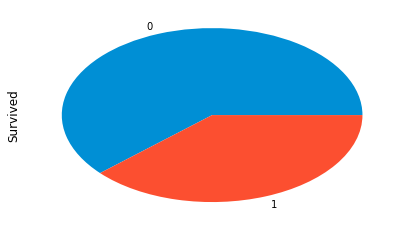

In [29]:
df.Survived.value_counts(normalize=True).plot(kind='pie')

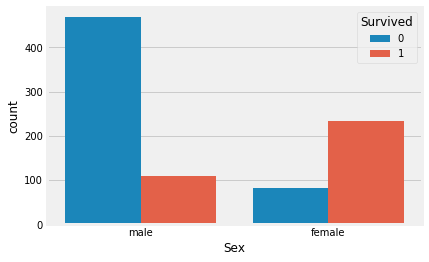

In [31]:
sns.countplot('Sex',hue='Survived',data=df)

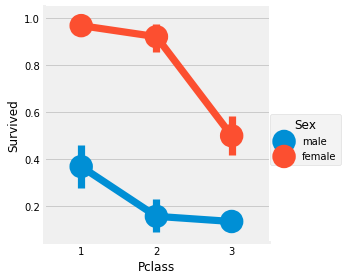

In [33]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df)

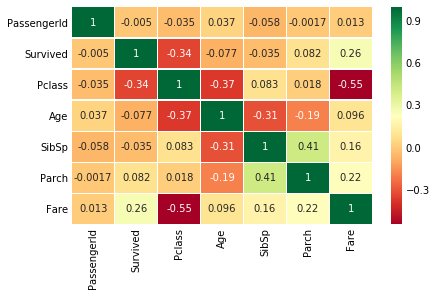

In [34]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

### Pre-Processing Data

In [35]:
df.Age.fillna(df.Age.mean(),inplace=True)

In [36]:
df.Embarked.fillna(df.Embarked.mode,inplace=True)

In [37]:
df.drop(["Name","Cabin","Ticket","PassengerId"],inplace=True,axis=1)

In [38]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [39]:
df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
496,1,1,female,54.000000,1,0,78.2667,C
398,0,2,male,23.000000,0,0,10.5000,S
88,1,1,female,23.000000,3,2,263.0000,S
605,0,3,male,36.000000,1,0,15.5500,S
613,0,3,male,29.699118,0,0,7.7500,Q


In [40]:
from sklearn.preprocessing import LabelEncoder

In [42]:
for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype('str'))

In [44]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,3
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,3
3,1,1,0,35.0,1,0,53.1000,3
4,0,3,1,35.0,0,0,8.0500,3


In [45]:
from sklearn.model_selection import train_test_split

In [46]:
train, test = train_test_split(df,test_size=0.2,random_state=0,stratify=df['Survived'])
train, validation = train_test_split(train,test_size=0.2,random_state=0,stratify=train['Survived'])

In [48]:
print(train.shape)
print(validation.shape)
print(test.shape)

(569, 8)
(143, 8)
(179, 8)


In [49]:
train.to_csv('train.csv', header=False, index=False)
validation.to_csv('validation.csv', header=False, index=False)
test.to_csv('test.csv', header=False, index=False)

In [55]:
bucket = 'freedom-developers-junk-bucket'
prefix = 'Surya'

### Write to S3 bucket ###

In [56]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### Model Training on Sagemaker ###

In [57]:
containers = {'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'}

In [58]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [59]:
s3_input_train

In [61]:
sess = sagemaker.Session()

In [62]:
xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/model'.format(bucket, prefix),
                                    sagemaker_session=sess)


In [63]:
boto3.Session().region_name

'us-east-1'

In [64]:
xgb.set_hyperparameters(max_depth=10,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [65]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-09-07-09-21-10-004


...................
Arguments: train
[2018-09-07:09:24:12:INFO] Running standalone xgboost training.
[2018-09-07:09:24:12:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8574.95mb
[2018-09-07:09:24:12:INFO] Determined delimiter of CSV input is ','
[09:24:12] S3DistributionType set as FullyReplicated
[09:24:12] 569x7 matrix with 3983 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-07:09:24:12:INFO] Determined delimiter of CSV input is ','
[09:24:12] S3DistributionType set as FullyReplicated
[09:24:12] 143x7 matrix with 1001 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[09:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]#011train-error:0.193322#011validation-error:0.153846
[09:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[1]#011train-e


Billable seconds: 92


### Model Deploy ###

In [69]:
!pip install xgboost

    100% |████████████████████████████████| 15.8MB 3.1MB/s eta 0:00:01
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [70]:
import pickle
import xgboost

In [71]:
xgb = pickle.load(open("xgboost-model","rb"))

In [72]:
xgb

In [73]:
import numpy 
from sagemaker.estimator import Estimator

In [75]:
model = Estimator.attach('xgboost-2018-09-07-09-21-10-004')

Arguments: train
[2018-09-07:09:24:12:INFO] Running standalone xgboost training.
[2018-09-07:09:24:12:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8574.95mb
[2018-09-07:09:24:12:INFO] Determined delimiter of CSV input is ','
[09:24:12] S3DistributionType set as FullyReplicated
[09:24:12] 569x7 matrix with 3983 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-07:09:24:12:INFO] Determined delimiter of CSV input is ','
[09:24:12] S3DistributionType set as FullyReplicated
[09:24:12] 143x7 matrix with 1001 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[09:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]#011train-error:0.193322#011validation-error:0.153846
[09:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[1]#011train-error:0.193322#011val

In [76]:
xgb_predictor = model.deploy(initial_instance_count=1,instance_type = 'ml.t2.medium')

INFO:sagemaker:Creating model with name: xgboost-2018-09-07-10-04-18-210
INFO:sagemaker:Creating endpoint with name xgboost-2018-09-07-09-21-10-004


---------------------------------------------------------------------------------------!

### Evaluate ###

In [93]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [94]:
def predict(data, rows=50):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')


In [95]:
test_data = pd.read_csv("test.csv")

In [96]:
predictions = predict(test_data.as_matrix()[:, 1:])

In [97]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,98,11
1,27,42


### Hyper Parameter Optimization ###

In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter    

hyperparameter_ranges = {'eta': ContinuousParameter(0.01, 0.2),
                         'num_round': IntegerParameter(100, 500),
                         'max_depth': IntegerParameter(3, 9),
                         'gamma': IntegerParameter(0, 5),
                         'min_child_weight': IntegerParameter(2, 6),
                         'subsample': ContinuousParameter(0.5, 0.9)}

objective_metric_name = 'validation:error'
objective_type='Minimize'
tuner = HyperparameterTuner(estimator = xgb, 
                    objective_metric_name = objective_metric_name , 
                    hyperparameter_ranges = hyperparameter_ranges, 
                    strategy='Bayesian', 
                    objective_type= objective_type, 
                    max_jobs=2, 
                    max_parallel_jobs=1)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
def  getTuningResultsgetTuning (tuning_job_name):
    sage_client = boto3.Session().client('sagemaker')
    tuning_job_name = tuning_job_name
    tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
    is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
    tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
    full_df = tuner.dataframe()

    if len(full_df) > 0:
        tuning_df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
        if len(tuning_df) > 0:
            tuning_df = tuning_df.sort_values('FinalObjectiveValue', ascending=is_minimize)
            print("Number of training jobs with valid objective: %d" % len(tuning_df))
            print({"lowest": min(tuning_df['FinalObjectiveValue']), "highest": max(tuning_df['FinalObjectiveValue'])})
            pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName
            return tuning_df
        else:
            print("No training jobs have reported valid results yet.")

    return full_df

In [ ]:
getTuningResultsgetTuning("xgboost-180905-1644")

### Training on Docker ###

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=random-forest-titanic

cd docker

chmod +x random_forest/train
chmod +x random_forest/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
#region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

In [ ]:
# Define IAM role
import boto3
import re
import sagemaker as sage
from time import gmtime, strftime
import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
sess = sage.Session()

In [ ]:
data_location = ''
model_location = ''

In [ ]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/random-forest-titanic'.format(account, region)

tree = sage.estimator.Estimator(image,
                        role, 1, 'ml.c4.2xlarge',
                        output_path=model_location,
                        sagemaker_session=sess)

In [ ]:
tree.set_hyperparameters(max_leaf_nodes=2)

In [ ]:
tree.fit(data_location)